## 7.5.MobileNetV2_from_Scratch_training_(10,100)_labels_500_epochs_with_aug

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Creando el modelo

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from imutils import paths
import numpy as np
import os

In [3]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'
path_checkpoints = 'checkpoint_MobileNetV2'

In [4]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['10', '100', 'unknown']
codificando etiquetas
[0 1 2]


In [5]:
input_shape = (img_size, img_size, 3)
base_model = MobileNetV2(
                    #include_top=True,
                    include_top=False,
                    #weights=None,
                    weights='imagenet',
                    input_shape=input_shape,
                    #pooling='max',
                    #classes=len(classNames_ids),
                    #classifier_activation='softmax'
                   )

In [6]:
for layer in base_model.layers:
    layer.trainable = True

In [7]:
model = tf.keras.Sequential([base_model,
                             Flatten(),
                             Dense(len(classNames_ids), activation='softmax')
                            ])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 188163    
Total params: 2,446,147
Trainable params: 2,412,035
Non-trainable params: 34,112
_________________________________________________________________


# Entrenamiento

In [9]:
batch_size = 64

In [10]:
generator = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
train_generator = generator.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                subset='training')
validation_generator = generator.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                subset='validation')

Found 14918 images belonging to 3 classes.
Found 3729 images belonging to 3 classes.


In [11]:
optimizer = SGD(learning_rate=0.0001, momentum=0.9)

loss = 'categorical_crossentropy'
metrics=["accuracy"]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [12]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-val_loss:{val_loss:.6f}-val_accuracy:{val_accuracy:.6f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)
callbacks = [checkpoint]
#callbacks = []

In [13]:
# load weigths
better_checkpoint = 'epoch-010-val_loss:0.023925-val_accuracy:0.992223.hdf5'
model.load_weights(path_checkpoints + '/' + better_checkpoint)

In [20]:
epochs = 500

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/500
234/234 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9999
Epoch 00001: val_loss improved from 0.02030 to 0.01764, saving model to checkpoint_MobileNetV2/epoch-001-val_loss:0.017637-val_accuracy:0.994368.hdf5
234/234 [==============================] - 65s 278ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0176 - val_accuracy: 0.9944
Epoch 2/500
234/234 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 00002: val_loss did not improve from 0.01764
234/234 [==============================] - 64s 275ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9936
Epoch 3/500
234/234 [==============================] - ETA: 0s - loss: 9.7350e-04 - accuracy: 1.0000
Epoch 00003: val_loss did not improve from 0.01764
234/234 [==============================] - 65s 278ms/step - loss: 9.7350e-04 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9941
Epoch 4/500
234/234 [==========================

234/234 [==============================] - ETA: 0s - loss: 5.5301e-04 - accuracy: 0.9999
Epoch 00025: val_loss did not improve from 0.01397
234/234 [==============================] - 65s 279ms/step - loss: 5.5301e-04 - accuracy: 0.9999 - val_loss: 0.0142 - val_accuracy: 0.9962
Epoch 26/500
234/234 [==============================] - ETA: 0s - loss: 4.6768e-04 - accuracy: 1.0000
Epoch 00026: val_loss improved from 0.01397 to 0.01392, saving model to checkpoint_MobileNetV2/epoch-026-val_loss:0.013922-val_accuracy:0.996246.hdf5
234/234 [==============================] - 65s 279ms/step - loss: 4.6768e-04 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 0.9962
Epoch 27/500
234/234 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996
Epoch 00027: val_loss improved from 0.01392 to 0.01379, saving model to checkpoint_MobileNetV2/epoch-027-val_loss:0.013786-val_accuracy:0.995441.hdf5
234/234 [==============================] - 65s 276ms/step - loss: 0.0014 - accuracy:

Epoch 51/500
234/234 [==============================] - ETA: 0s - loss: 6.9038e-04 - accuracy: 0.9999
Epoch 00051: val_loss improved from 0.01134 to 0.01078, saving model to checkpoint_MobileNetV2/epoch-051-val_loss:0.010783-val_accuracy:0.997855.hdf5
234/234 [==============================] - 65s 277ms/step - loss: 6.9038e-04 - accuracy: 0.9999 - val_loss: 0.0108 - val_accuracy: 0.9979
Epoch 52/500
234/234 [==============================] - ETA: 0s - loss: 3.0490e-04 - accuracy: 1.0000
Epoch 00052: val_loss improved from 0.01078 to 0.01075, saving model to checkpoint_MobileNetV2/epoch-052-val_loss:0.010746-val_accuracy:0.997855.hdf5
234/234 [==============================] - 65s 278ms/step - loss: 3.0490e-04 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9979
Epoch 53/500
234/234 [==============================] - ETA: 0s - loss: 3.0147e-04 - accuracy: 0.9999
Epoch 00053: val_loss improved from 0.01075 to 0.01073, saving model to checkpoint_MobileNetV2/epoch-053-val_loss:0.01

234/234 [==============================] - ETA: 0s - loss: 2.2590e-04 - accuracy: 1.0000
Epoch 00076: val_loss did not improve from 0.00966
234/234 [==============================] - 65s 276ms/step - loss: 2.2590e-04 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 0.9989
Epoch 77/500
234/234 [==============================] - ETA: 0s - loss: 7.8506e-04 - accuracy: 0.9998
Epoch 00077: val_loss did not improve from 0.00966
234/234 [==============================] - 65s 278ms/step - loss: 7.8506e-04 - accuracy: 0.9998 - val_loss: 0.0098 - val_accuracy: 0.9984
Epoch 78/500
234/234 [==============================] - ETA: 0s - loss: 3.4121e-04 - accuracy: 1.0000
Epoch 00078: val_loss did not improve from 0.00966
234/234 [==============================] - 65s 277ms/step - loss: 3.4121e-04 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9981
Epoch 79/500
234/234 [==============================] - ETA: 0s - loss: 1.9837e-04 - accuracy: 1.0000
Epoch 00079: val_loss did not improve 

234/234 [==============================] - ETA: 0s - loss: 1.6256e-04 - accuracy: 1.0000
Epoch 00104: val_loss did not improve from 0.00966
234/234 [==============================] - 65s 277ms/step - loss: 1.6256e-04 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9984
Epoch 105/500
234/234 [==============================] - ETA: 0s - loss: 1.4465e-04 - accuracy: 1.0000
Epoch 00105: val_loss did not improve from 0.00966
234/234 [==============================] - 65s 280ms/step - loss: 1.4465e-04 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9984
Epoch 106/500
234/234 [==============================] - ETA: 0s - loss: 1.8988e-04 - accuracy: 1.0000
Epoch 00106: val_loss did not improve from 0.00966
234/234 [==============================] - 65s 276ms/step - loss: 1.8988e-04 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9968
Epoch 107/500
234/234 [==============================] - ETA: 0s - loss: 2.7488e-04 - accuracy: 1.0000
Epoch 00107: val_loss did not impro

234/234 [==============================] - ETA: 0s - loss: 2.1222e-04 - accuracy: 1.0000
Epoch 00131: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 278ms/step - loss: 2.1222e-04 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9984
Epoch 132/500
234/234 [==============================] - ETA: 0s - loss: 1.4171e-04 - accuracy: 1.0000
Epoch 00132: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 1.4171e-04 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9984
Epoch 133/500
234/234 [==============================] - ETA: 0s - loss: 1.4312e-04 - accuracy: 1.0000
Epoch 00133: val_loss did not improve from 0.00896
234/234 [==============================] - 64s 275ms/step - loss: 1.4312e-04 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 0.9984
Epoch 134/500
234/234 [==============================] - ETA: 0s - loss: 1.7988e-04 - accuracy: 1.0000
Epoch 00134: val_loss did not impro

234/234 [==============================] - ETA: 0s - loss: 1.8085e-04 - accuracy: 0.9999
Epoch 00159: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 1.8085e-04 - accuracy: 0.9999 - val_loss: 0.0109 - val_accuracy: 0.9979
Epoch 160/500
234/234 [==============================] - ETA: 0s - loss: 1.2597e-04 - accuracy: 1.0000
Epoch 00160: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 279ms/step - loss: 1.2597e-04 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9981
Epoch 161/500
234/234 [==============================] - ETA: 0s - loss: 1.0165e-04 - accuracy: 1.0000
Epoch 00161: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 279ms/step - loss: 1.0165e-04 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 0.9981
Epoch 162/500
234/234 [==============================] - ETA: 0s - loss: 8.9930e-05 - accuracy: 1.0000
Epoch 00162: val_loss did not impro

234/234 [==============================] - ETA: 0s - loss: 7.6080e-05 - accuracy: 1.0000
Epoch 00187: val_loss did not improve from 0.00896
234/234 [==============================] - 66s 281ms/step - loss: 7.6080e-05 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9979
Epoch 188/500
234/234 [==============================] - ETA: 0s - loss: 1.0063e-04 - accuracy: 1.0000
Epoch 00188: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 279ms/step - loss: 1.0063e-04 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9981
Epoch 189/500
234/234 [==============================] - ETA: 0s - loss: 9.4721e-05 - accuracy: 1.0000
Epoch 00189: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 276ms/step - loss: 9.4721e-05 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9981
Epoch 190/500
234/234 [==============================] - ETA: 0s - loss: 6.4734e-05 - accuracy: 1.0000
Epoch 00190: val_loss did not impro

234/234 [==============================] - ETA: 0s - loss: 1.3371e-04 - accuracy: 1.0000
Epoch 00215: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 1.3371e-04 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9968
Epoch 216/500
234/234 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 00216: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0183 - val_accuracy: 0.9957
Epoch 217/500
234/234 [==============================] - ETA: 0s - loss: 1.1879e-04 - accuracy: 1.0000
Epoch 00217: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 1.1879e-04 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 0.9962
Epoch 218/500
234/234 [==============================] - ETA: 0s - loss: 1.9793e-04 - accuracy: 1.0000
Epoch 00218: val_loss did not improve from 

234/234 [==============================] - ETA: 0s - loss: 1.2737e-04 - accuracy: 1.0000
Epoch 00243: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 279ms/step - loss: 1.2737e-04 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 0.9981
Epoch 244/500
234/234 [==============================] - ETA: 0s - loss: 1.2233e-04 - accuracy: 1.0000
Epoch 00244: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 1.2233e-04 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9979
Epoch 245/500
234/234 [==============================] - ETA: 0s - loss: 1.2302e-04 - accuracy: 1.0000
Epoch 00245: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 1.2302e-04 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9973
Epoch 246/500
234/234 [==============================] - ETA: 0s - loss: 1.8069e-04 - accuracy: 1.0000
Epoch 00246: val_loss did not impro

234/234 [==============================] - ETA: 0s - loss: 4.0218e-04 - accuracy: 0.9998
Epoch 00271: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 278ms/step - loss: 4.0218e-04 - accuracy: 0.9998 - val_loss: 0.0128 - val_accuracy: 0.9976
Epoch 272/500
234/234 [==============================] - ETA: 0s - loss: 3.4521e-04 - accuracy: 0.9999
Epoch 00272: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 3.4521e-04 - accuracy: 0.9999 - val_loss: 0.0122 - val_accuracy: 0.9981
Epoch 273/500
234/234 [==============================] - ETA: 0s - loss: 5.6303e-05 - accuracy: 1.0000
Epoch 00273: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 278ms/step - loss: 5.6303e-05 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9981
Epoch 274/500
234/234 [==============================] - ETA: 0s - loss: 5.7925e-05 - accuracy: 1.0000
Epoch 00274: val_loss did not impro

234/234 [==============================] - ETA: 0s - loss: 9.0483e-05 - accuracy: 1.0000
Epoch 00299: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 9.0483e-05 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 0.9984
Epoch 300/500
234/234 [==============================] - ETA: 0s - loss: 9.1722e-04 - accuracy: 0.9998
Epoch 00300: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 278ms/step - loss: 9.1722e-04 - accuracy: 0.9998 - val_loss: 0.0154 - val_accuracy: 0.9949
Epoch 301/500
234/234 [==============================] - ETA: 0s - loss: 1.7600e-04 - accuracy: 1.0000
Epoch 00301: val_loss did not improve from 0.00896
234/234 [==============================] - 65s 277ms/step - loss: 1.7600e-04 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9973
Epoch 302/500
234/234 [==============================] - ETA: 0s - loss: 3.5212e-04 - accuracy: 0.9999
Epoch 00302: val_loss did not impro

234/234 [==============================] - ETA: 0s - loss: 5.7511e-05 - accuracy: 1.0000
Epoch 00326: val_loss did not improve from 0.00827
234/234 [==============================] - 65s 277ms/step - loss: 5.7511e-05 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 0.9987
Epoch 327/500
234/234 [==============================] - ETA: 0s - loss: 1.3812e-04 - accuracy: 0.9999
Epoch 00327: val_loss did not improve from 0.00827
234/234 [==============================] - 65s 277ms/step - loss: 1.3812e-04 - accuracy: 0.9999 - val_loss: 0.0118 - val_accuracy: 0.9971
Epoch 328/500
234/234 [==============================] - ETA: 0s - loss: 4.1661e-04 - accuracy: 0.9999
Epoch 00328: val_loss did not improve from 0.00827
234/234 [==============================] - 66s 281ms/step - loss: 4.1661e-04 - accuracy: 0.9999 - val_loss: 0.0110 - val_accuracy: 0.9973
Epoch 329/500
234/234 [==============================] - ETA: 0s - loss: 8.7761e-04 - accuracy: 0.9998
Epoch 00329: val_loss did not impro

Epoch 351/500
234/234 [==============================] - ETA: 0s - loss: 6.1249e-05 - accuracy: 1.0000
Epoch 00351: val_loss did not improve from 0.00787
234/234 [==============================] - 65s 277ms/step - loss: 6.1249e-05 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9987
Epoch 352/500
234/234 [==============================] - ETA: 0s - loss: 3.7109e-05 - accuracy: 1.0000
Epoch 00352: val_loss improved from 0.00787 to 0.00786, saving model to checkpoint_MobileNetV2/epoch-352-val_loss:0.007863-val_accuracy:0.998659.hdf5
234/234 [==============================] - 65s 277ms/step - loss: 3.7109e-05 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9987
Epoch 353/500
234/234 [==============================] - ETA: 0s - loss: 4.2657e-05 - accuracy: 1.0000
Epoch 00353: val_loss improved from 0.00786 to 0.00782, saving model to checkpoint_MobileNetV2/epoch-353-val_loss:0.007824-val_accuracy:0.998659.hdf5
234/234 [==============================] - 65s 276ms/step - loss

Epoch 378/500
234/234 [==============================] - ETA: 0s - loss: 5.9540e-04 - accuracy: 0.9999
Epoch 00378: val_loss did not improve from 0.00761
234/234 [==============================] - 65s 278ms/step - loss: 5.9540e-04 - accuracy: 0.9999 - val_loss: 0.0103 - val_accuracy: 0.9976
Epoch 379/500
234/234 [==============================] - ETA: 0s - loss: 9.6934e-05 - accuracy: 1.0000
Epoch 00379: val_loss did not improve from 0.00761
234/234 [==============================] - 65s 277ms/step - loss: 9.6934e-05 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9979
Epoch 380/500
234/234 [==============================] - ETA: 0s - loss: 7.3659e-05 - accuracy: 1.0000
Epoch 00380: val_loss did not improve from 0.00761
234/234 [==============================] - 65s 276ms/step - loss: 7.3659e-05 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9979
Epoch 381/500
234/234 [==============================] - ETA: 0s - loss: 3.9072e-05 - accuracy: 1.0000
Epoch 00381: val_loss

234/234 [==============================] - ETA: 0s - loss: 4.1257e-05 - accuracy: 1.0000
Epoch 00406: val_loss did not improve from 0.00761
234/234 [==============================] - 65s 276ms/step - loss: 4.1257e-05 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 0.9984
Epoch 407/500
234/234 [==============================] - ETA: 0s - loss: 9.6149e-05 - accuracy: 1.0000
Epoch 00407: val_loss did not improve from 0.00761
234/234 [==============================] - 65s 276ms/step - loss: 9.6149e-05 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9984
Epoch 408/500
234/234 [==============================] - ETA: 0s - loss: 2.7389e-04 - accuracy: 0.9999
Epoch 00408: val_loss did not improve from 0.00761
234/234 [==============================] - 65s 277ms/step - loss: 2.7389e-04 - accuracy: 0.9999 - val_loss: 0.0090 - val_accuracy: 0.9984
Epoch 409/500
234/234 [==============================] - ETA: 0s - loss: 4.1906e-05 - accuracy: 1.0000
Epoch 00409: val_loss did not impro

234/234 [==============================] - ETA: 0s - loss: 2.6591e-05 - accuracy: 1.0000
Epoch 00434: val_loss did not improve from 0.00761
234/234 [==============================] - 66s 281ms/step - loss: 2.6591e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9987
Epoch 435/500
234/234 [==============================] - ETA: 0s - loss: 3.0902e-05 - accuracy: 1.0000
Epoch 00435: val_loss did not improve from 0.00761
234/234 [==============================] - 65s 277ms/step - loss: 3.0902e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9987
Epoch 436/500
234/234 [==============================] - ETA: 0s - loss: 3.6166e-05 - accuracy: 1.0000
Epoch 00436: val_loss did not improve from 0.00761
234/234 [==============================] - 65s 278ms/step - loss: 3.6166e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9987
Epoch 437/500
234/234 [==============================] - ETA: 0s - loss: 3.4299e-05 - accuracy: 1.0000
Epoch 00437: val_loss did not impro

Epoch 462/500
234/234 [==============================] - ETA: 0s - loss: 2.7633e-04 - accuracy: 1.0000
Epoch 00462: val_loss did not improve from 0.00706
234/234 [==============================] - 65s 279ms/step - loss: 2.7633e-04 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9949
Epoch 463/500
234/234 [==============================] - ETA: 0s - loss: 1.5668e-04 - accuracy: 0.9999
Epoch 00463: val_loss did not improve from 0.00706
234/234 [==============================] - 65s 277ms/step - loss: 1.5668e-04 - accuracy: 0.9999 - val_loss: 0.0113 - val_accuracy: 0.9962
Epoch 464/500
234/234 [==============================] - ETA: 0s - loss: 1.6396e-04 - accuracy: 0.9999
Epoch 00464: val_loss did not improve from 0.00706
234/234 [==============================] - 65s 277ms/step - loss: 1.6396e-04 - accuracy: 0.9999 - val_loss: 0.0094 - val_accuracy: 0.9973
Epoch 465/500
234/234 [==============================] - ETA: 0s - loss: 7.0748e-05 - accuracy: 1.0000
Epoch 00465: val_loss

Epoch 489/500
234/234 [==============================] - ETA: 0s - loss: 9.4413e-05 - accuracy: 1.0000
Epoch 00489: val_loss did not improve from 0.00664
234/234 [==============================] - 65s 279ms/step - loss: 9.4413e-05 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9984
Epoch 490/500
234/234 [==============================] - ETA: 0s - loss: 5.3118e-05 - accuracy: 1.0000
Epoch 00490: val_loss did not improve from 0.00664
234/234 [==============================] - 65s 279ms/step - loss: 5.3118e-05 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9984
Epoch 491/500
234/234 [==============================] - ETA: 0s - loss: 4.8918e-05 - accuracy: 1.0000
Epoch 00491: val_loss did not improve from 0.00664
234/234 [==============================] - 65s 276ms/step - loss: 4.8918e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9987
Epoch 492/500
234/234 [==============================] - ETA: 0s - loss: 4.3952e-05 - accuracy: 1.0000
Epoch 00492: val_loss

# Gráfica

In [21]:
import matplotlib.pyplot as plt

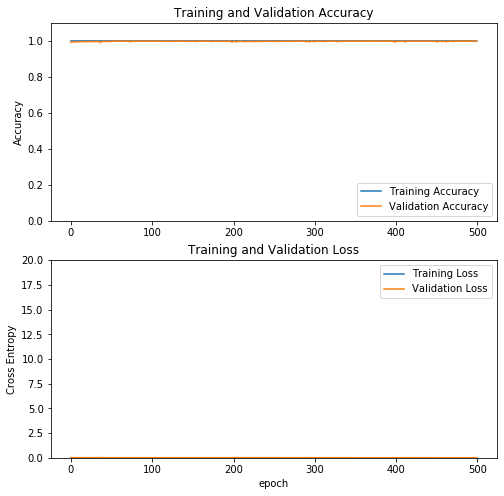

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Testing model

In [23]:
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt

In [24]:
models = [model]

INFO:tensorflow:Load image with size: 2671, num_label: 3, labels: 10, 100, unknown.


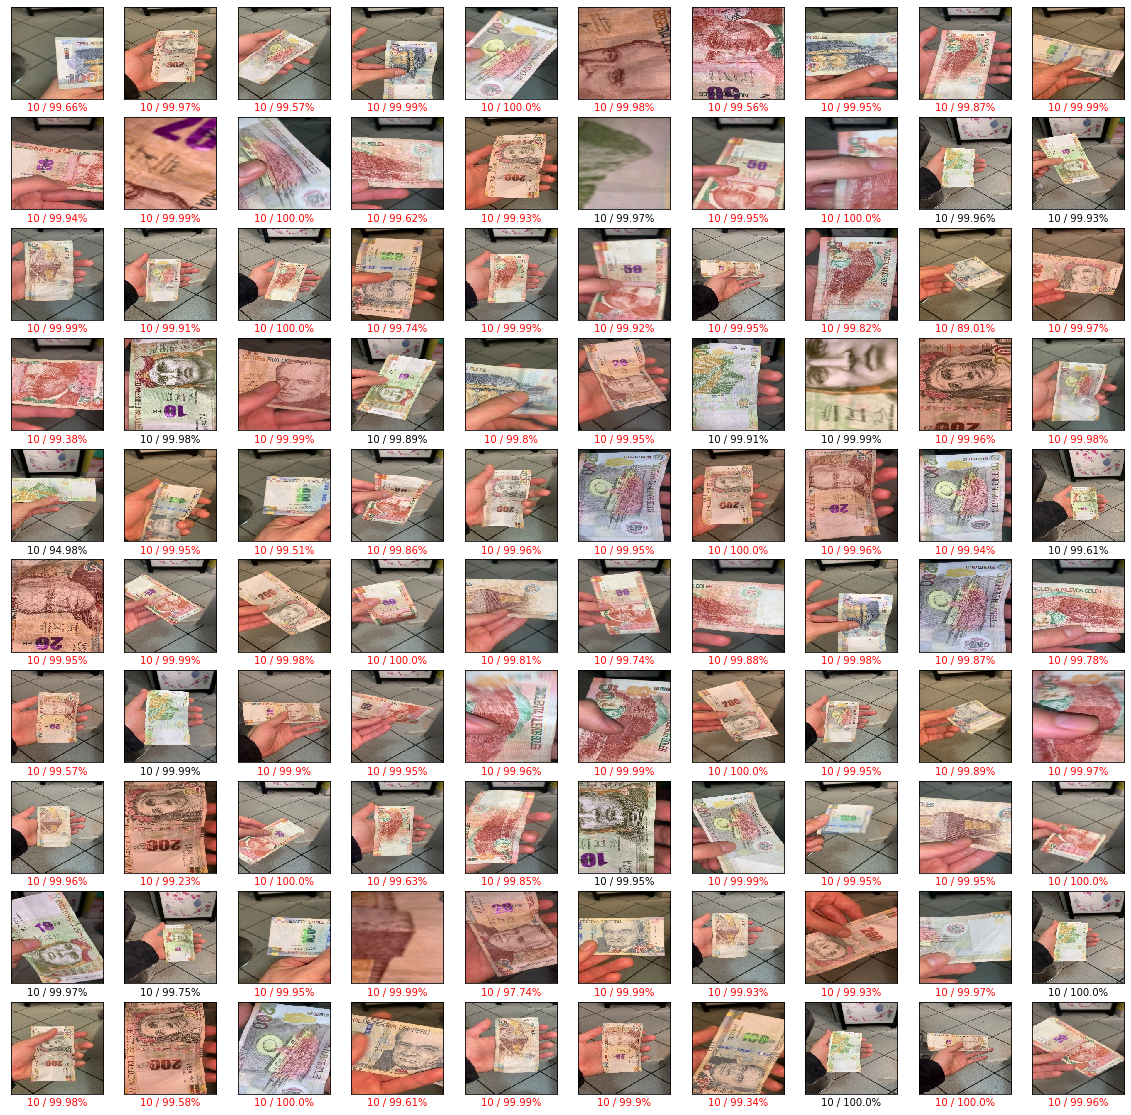

In [25]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    #predict
    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    
    #utilizando el average de los modelos para la predicción
    predictions = []
    #counter = 0
    for model in models:
        #if counter == 0:
        #    print('==========')
        #if counter > 2:
        #    counter = 0
        #print(np.argmax(model.predict(arr4d)))
        #print(classNames[np.argmax(model.predict(arr4d))])
        predictions.append(model.predict(arr4d))
        #counter += 1
    prediction_average = np.average(predictions, axis=0)
    #print(prediction_average)
    #print('==')
    id_predict = np.argmax(prediction_average)
    percentage = round(prediction_average[0][id_predict] * 100, 2)
    predict_label = classNames[id_predict]
    
    #print(prediction_average * 100)
    #print(id_predict)
    #print('==============')
    
    #setup color
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    image_label = predict_label + ' / ' + str(percentage) + '%'
    plt.xlabel(image_label)
plt.show()